<a href="https://colab.research.google.com/github/DiGyt/snippets/blob/master/deepest_dive_into_music.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [834]:
import io
import base64
import numpy as np
import scipy.io.wavfile as wavfile
from scipy.signal import butter, lfilter, stft, istft
import matplotlib.pyplot as plt
from IPython.display import HTML


In [923]:
# Correct Bjorklund / Euclidean rhythm
def euclidean_rhythm(k, n):
    pattern = [0]*n
    for i in range(k):
        pattern[(i * n) // k] = 1
    if k == 5 and n == 32:
      pattern[25] = 0
      pattern[26] = 1
    return pattern



def euclidean_loop_audio(k=5, n=16, bpm=120, bars=4, sr=44100):

    # Generate Euclidean pattern
    pattern = euclidean_rhythm(k, n)

    # Step duration in samples
    step_time = 60 / bpm / 4
    step_samples = int(step_time * sr)

    t, click = pulse(sr)

    # Make sure pulse fits in step
    if len(click) > step_samples:
        click = click[:step_samples]

    # Fill the bar with pulses
    bar = np.zeros(step_samples * n)
    for i, step in enumerate(pattern):
        if step:
            bar[i*step_samples:i*step_samples+len(click)] += click

    # Tile for bars
    audio = np.tile(bar, bars)
    audio /= np.max(np.abs(audio))
    return audio


def play_with_waveform_interface(audios, sr=44100, width=800, height=100, threshold=0.003):

    if not isinstance(audios, list):
        audios = [audios]

    wav_datas = []
    precomputed = []

    for audio in audios:
        # normalize
        #audio = audio / max(1e-12, np.max(np.abs(audio)))
        buf = io.BytesIO()
        wavfile.write(buf, sr, (audio*32767).astype(np.int16))
        b64 = base64.b64encode(buf.getvalue()).decode()
        wav_datas.append(b64)

        # precompute waveform and pattern once
        step = max(1, len(audio)//width)
        samples = [float(np.max(np.abs(audio[i:i+step]))) for i in range(0, len(audio), step)]
        pattern = [1 if s>threshold else 0 for s in samples]
        precomputed.append((samples, pattern))

    html_tracks = ""
    for idx, (b64, (samples, pattern)) in enumerate(zip(wav_datas, precomputed)):
        html_tracks += f"""
<div style="display:flex; align-items:center; margin-bottom:20px;">
  <canvas id="wave{idx}" width="{width}" height="{height}" style="border:1px solid #ccc;"></canvas>
  <canvas id="circle{idx}" width="{height}" height="{height}" style="margin-left:20px;"></canvas>
  <audio id="audio{idx}" controls loop style="margin-left:10px;">
    <source src="data:audio/wav;base64,{b64}" type="audio/wav">
  </audio>
</div>
"""

    # JavaScript
    js_all = "<script>(function(){\n"
    js_all += """
if (!window.currentAudios) window.currentAudios=[];
if (!window.currentAnimations) window.currentAnimations=[];
window.currentAudios.forEach(a=>a.pause());
window.currentAnimations.forEach(a=>cancelAnimationFrame(a));
window.currentAudios=[]; window.currentAnimations=[];
"""

    for idx, (samples, pattern) in enumerate(precomputed):
        waveform_js = ",".join(f"{s:.4f}" for s in samples)
        pattern_js = ",".join(str(p) for p in pattern)

        js_all += f"""
const canvas{idx}=document.getElementById("wave{idx}");
const ctx{idx}=canvas{idx}.getContext("2d");
const canvasC{idx}=document.getElementById("circle{idx}");
const ctxC{idx}=canvasC{idx}.getContext("2d");
const audio{idx}=document.getElementById("audio{idx}");
audio{idx}.pause();
window.currentAudios.push(audio{idx});
const waveform{idx}=[{waveform_js}];
const pattern{idx}=[{pattern_js}];
const mid{idx}=canvas{idx}.height/2;
const radius{idx}=mid{idx}-5;

function draw{idx}(){{
    // Waveform
    ctx{idx}.clearRect(0,0,canvas{idx}.width,canvas{idx}.height);
    ctx{idx}.beginPath();
    ctx{idx}.moveTo(0,mid{idx});
    waveform{idx}.forEach((v,i)=>{{
        const x=i*canvas{idx}.width/waveform{idx}.length;
        const y=mid{idx}-v*mid{idx}*0.9;
        ctx{idx}.lineTo(x,y);
    }});
    ctx{idx}.strokeStyle="#444"; ctx{idx}.stroke();

    // Waveform playhead
    if(!audio{idx}.paused){{
        const x=(audio{idx}.currentTime%audio{idx}.duration)/audio{idx}.duration*canvas{idx}.width;
        ctx{idx}.beginPath();
        ctx{idx}.moveTo(x,0);
        ctx{idx}.lineTo(x,canvas{idx}.height);
        ctx{idx}.strokeStyle="red"; ctx{idx}.lineWidth=2; ctx{idx}.stroke();
    }}

    // Circle with tick markers
    ctxC{idx}.clearRect(0,0,canvasC{idx}.width,canvasC{idx}.height);
    const cx=canvasC{idx}.width/2;
    const cy=canvasC{idx}.height/2;
    const n=pattern{idx}.length;
    const innerR=radius{idx}-6;
    const outerR=radius{idx};

    for(let i=0;i<n;i++){{
        if(pattern{idx}[i]){{
            const angle=i/n*2*Math.PI-Math.PI/2;
            const x1=cx+innerR*Math.cos(angle);
            const y1=cy+innerR*Math.sin(angle);
            const x2=cx+outerR*Math.cos(angle);
            const y2=cy+outerR*Math.sin(angle);
            ctxC{idx}.beginPath();
            ctxC{idx}.moveTo(x1,y1);
            ctxC{idx}.lineTo(x2,y2);
            ctxC{idx}.strokeStyle="#444";
            ctxC{idx}.lineWidth=2;
            ctxC{idx}.stroke();
        }}
    }}

    // Playhead
    const t=audio{idx}.currentTime;
    const progress=(t%audio{idx}.duration)/audio{idx}.duration;
    const angle=progress*2*Math.PI-Math.PI/2;
    const x=cx+radius{idx}*Math.cos(angle);
    const y=cy+radius{idx}*Math.sin(angle);
    ctxC{idx}.beginPath();
    ctxC{idx}.moveTo(cx,cy);
    ctxC{idx}.lineTo(x,y);
    ctxC{idx}.strokeStyle="red";
    ctxC{idx}.lineWidth=2;
    ctxC{idx}.stroke();

    window.currentAnimations.push(requestAnimationFrame(draw{idx}));
}}
draw{idx}();
"""

    # **Synchronized start**: only start after all audios are ready
    js_all += """
const startTime = performance.now() + 100;
window.currentAudios.forEach(a=>{
    const delay = startTime - performance.now();
    setTimeout(()=>a.play(), Math.max(0, delay));
});
"""
    js_all += "})();</script>"

    return HTML(html_tracks + js_all)




In [524]:


def volume(audio, db=0):
    """Adjust volume in dB"""
    factor = 10**(db / 20)
    return audio * factor


def lowpass(audio, sr=44100, cutoff=1000):
    b, a = butter(2, cutoff / (sr/2), btype='low')
    return lfilter(b, a, audio)

def highpass(audio, sr=44100, cutoff=500):
    b, a = butter(2, cutoff / (sr/2), btype='high')
    return lfilter(b, a, audio)


def echo(audio, sr=44100, delay=0.2, decay=0.5):
    """Add simple echo: delay in seconds, decay factor"""
    n_delay = int(sr * delay)
    output = np.copy(audio)
    for i in range(n_delay, len(audio)):
        output[i] += decay * output[i - n_delay]
    return output / np.max(np.abs(output))  # normalize to avoid clipping

def pan(audio, pan=0.0):
    """Convert mono to stereo with pan (-1 left, 1 right)"""
    left = audio * (1 - pan)/2
    right = audio * (1 + pan)/2
    return np.stack([left, right], axis=1)


def eq(audio, sr=44100, low=None, high=None):
    """Apply optional lowpass/highpass filtering"""
    if low:
        audio = lowpass(audio, sr, low)
    if high:
        audio = highpass(audio, sr, high)
    return audio

def saturate(audio, gain=2.0):
    audio = audio * gain
    audio = np.tanh(audio)  # soft clip
    return audio / np.max(np.abs(audio))

def offset(audio, sr=44100, seconds=0.0):
    """
    Shift an audio signal in time by `seconds`.
    """
    n_shift = int(seconds * sr)  # number of samples to shift
    return np.roll(audio, n_shift)

def envelope(audio, sr=44100, start=0.0, stop=None):
    """
    Apply a time-based envelope to an audio signal.
    Everything before `start` seconds and after `stop` seconds is zeroed.
    """
    out = np.copy(audio)
    n_start = int(start * sr)
    n_stop = int(stop * sr) if stop is not None else len(audio)

    out[:n_start] = 0
    out[n_stop:] = 0

    return out

def sample_envelope(audio, start=0.0, stop=1.0):
    """
    Apply an envelope to an audio signal using fractional positions of the sample array.
    Everything before `start` and after `stop` is zeroed.
    """
    n = len(audio)
    n_start = int(np.clip(start, 0.0, 1.0) * n)
    n_stop = int(np.clip(stop, 0.0, 1.0) * n)

    out = np.copy(audio)
    out[:n_start] = 0
    out[n_stop:] = 0
    return out


def add_noise(audio, gain=0.05, threshold=0.001):
    """
    Add subtle noise only where the signal is non-zero (above threshold)
    """
    mask = np.abs(audio) > threshold
    noise = np.random.randn(len(audio)) * gain
    output = np.copy(audio)
    output[mask] += noise[mask]
    return output


def limiter(audio, threshold=0.8):
    peak = np.max(np.abs(audio))
    if peak > threshold:
        audio = audio * (threshold / peak)
    return audio


def reverb(audio, sr=44100, decay=0.5, pre_delay=0.01, wet=0.3):
    """
    Simple modular reverb.

    Parameters:
        audio : np.array - input mono audio
        sr : int - sample rate
        decay : float - how long the reverb tail is (0..1)
        pre_delay : float - initial delay before reverb in seconds
        wet : float - how much reverb to mix (0..1)
    Returns:
        np.array - audio with reverb, same length as input
    """
    n_delay = int(pre_delay * sr)
    output = np.copy(audio)
    # Feedback comb (simple tail)
    for i in range(n_delay, len(audio)):
        output[i] += decay * output[i - n_delay]

    # Mix original and wet signal
    out = (1 - wet) * audio + wet * output
    # normalize
    out /= max(1e-12, np.max(np.abs(out)))
    return out


def sequencer_pitch(audio, steps, ratios, grain_size=256, overlap=0.5):
    """
    Granular pitch sequencer.
    Changes pitch WITHOUT changing duration.

    Parameters
    ----------
    audio : np.ndarray (mono)
    steps : list of floats (0..1) – segment boundaries
    ratios : list of floats – pitch ratios per segment
    grain_size : int – grain length in samples
    overlap : float (0..1)

    Returns
    -------
    np.ndarray – same length as input
    """

    n = len(audio)
    output = np.zeros(n)
    hop = int(grain_size * (1 - overlap))

    # Safety
    if hop < 1:
        hop = 1

    # Window
    window = np.hanning(grain_size)

    # Convert fractional steps → sample ranges
    step_samples = [int(s * n) for s in steps] + [n]

    for seg in range(len(ratios)):
        start = step_samples[seg]
        end = step_samples[seg + 1]
        ratio = ratios[seg]

        write_pos = start
        read_pos = start

        while write_pos + grain_size < end:
            # Read grain with pitch shift
            idx = read_pos + np.arange(grain_size) * ratio
            idx = idx.astype(int)

            # Clamp read index
            idx = np.clip(idx, 0, n - 1)

            grain = audio[idx] * window

            # Overlap-add
            output[write_pos:write_pos + grain_size] += grain

            write_pos += hop
            read_pos += hop

    # Normalize safely (preserve loudness perception)
    peak = np.max(np.abs(output))
    if peak > 1e-9:
        output /= peak

    return output

def match_length(audio, target_audio):
    """
    Adjust `audio` to have the same length as `target_audio`.
    If audio is too short, it is looped; if too long, it is truncated.
    """
    target_len = len(target_audio)
    audio_len = len(audio)

    if audio_len == target_len:
        return audio.copy()  # already matching

    elif audio_len > target_len:
        # truncate
        return audio[:target_len]

    else:
        # repeat and truncate to match
        n_repeats = target_len // audio_len + 1
        audio_looped = np.tile(audio, n_repeats)
        return audio_looped[:target_len]


def phaser_lowpass(audio, sr=44100, rate=0.25, depth=0.7, cutoff_min=500, cutoff_max=5000):
    """
    Applies a sweeping lowpass filter modulated by a sine LFO (phasor effect).

    Parameters
    ----------
    audio : np.ndarray
        Input mono audio.
    sr : int
        Sample rate in Hz.
    rate : float
        LFO rate in Hz.
    depth : float
        Depth of modulation (0..1).
    cutoff_min : float
        Minimum cutoff frequency of lowpass.
    cutoff_max : float
        Maximum cutoff frequency of lowpass.

    Returns
    -------
    np.ndarray
        Filtered audio.
    """
    # Create LFO for cutoff modulation
    n = len(audio)
    t = np.arange(n) / sr
    lfo = 0.5 * (1 + np.sin(2 * np.pi * rate * t))  # 0..1
    cutoff = cutoff_min + depth * (cutoff_max - cutoff_min) * lfo

    # Initialize output
    out = np.zeros_like(audio)
    x1, x2, y1, y2 = 0, 0, 0, 0  # biquad state

    for i in range(n):
        # Calculate lowpass coefficients using simple RC filter formula
        fc = cutoff[i]
        w0 = 2 * np.pi * fc / sr
        alpha = np.sin(w0) / 2
        cos_w0 = np.cos(w0)
        b0 = (1 - cos_w0) / 2
        b1 = 1 - cos_w0
        b2 = (1 - cos_w0) / 2
        a0 = 1 + alpha
        a1 = -2 * cos_w0
        a2 = 1 - alpha

        # Apply biquad difference equation
        out[i] = (b0/a0)*audio[i] + (b1/a0)*x1 + (b2/a0)*x2 - (a1/a0)*y1 - (a2/a0)*y2

        # Shift delay buffers
        x2, x1 = x1, audio[i]
        y2, y1 = y1, out[i]

    # Normalize to prevent clipping
    out /= max(1e-12, np.max(np.abs(out)))
    return out


def adsr(audio, sr=44100, attack=0.01, decay=0.1, sustain=0.7, release=0.2, fraction=1.0):
    """
    Apply an ADSR envelope to audio, treating each 'note' as a fraction of the audio.

    Parameters
    ----------
    audio : np.ndarray
        Input mono audio.
    sr : int
        Sample rate in Hz.
    attack : float
        Attack time in seconds.
    decay : float
        Decay time in seconds.
    sustain : float
        Sustain level (0..1).
    release : float
        Release time in seconds.
    fraction : float
        Fraction of audio to treat as one 'note' (0 < fraction <= 1).

    Returns
    -------
    np.ndarray
        Audio with ADSR applied.
    """
    n = len(audio)
    out = np.zeros_like(audio)

    # Determine note length in samples
    note_len = int(n * fraction)
    if note_len < 1:
        return audio.copy()  # nothing to do

    # Build ADSR envelope in samples
    a_len = int(attack * sr)
    d_len = int(decay * sr)
    r_len = int(release * sr)
    s_level = sustain

    # Ensure envelope fits within note length
    total_env_len = a_len + d_len + r_len
    if total_env_len > note_len:
        scale = note_len / total_env_len
        a_len = int(a_len * scale)
        d_len = int(d_len * scale)
        r_len = int(r_len * scale)

    s_len = note_len - (a_len + d_len + r_len)

    # Construct single-note envelope
    env = np.concatenate([
        np.linspace(0, 1, a_len, endpoint=False),                # attack
        np.linspace(1, s_level, d_len, endpoint=False),          # decay
        np.full(s_len, s_level),                                 # sustain
        np.linspace(s_level, 0, r_len, endpoint=False)           # release
    ])

    # Repeat the envelope over the audio
    for start in range(0, n, note_len):
        end = min(start + note_len, n)
        env_slice = env[:end-start]  # truncate if at the end
        out[start:end] = audio[start:end] * env_slice

    return out


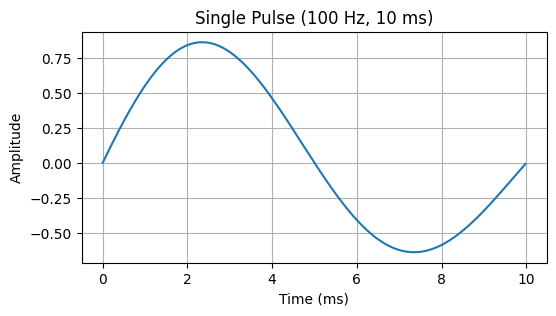

In [525]:


def pulse(sr=44100, duration=0.01, freq=100):
    t = np.linspace(0, duration, int(sr*duration), False)
    p = np.sin(2*np.pi*freq*t) * np.exp(-60*t)
    return t, p

# Generate the pulse
t, p = pulse(sr=44100, duration=0.01, freq=100)

# Plot it
plt.figure(figsize=(6,3))
plt.plot(t*1000, p)  # convert time to milliseconds
plt.title("Single Pulse (100 Hz, 10 ms)")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


In [561]:
sr = 44100
audio = euclidean_loop_audio(k=5, n=16, bpm=120, bars=1, sr=sr)
play_with_waveform_interface([audio], sr)


In [914]:
sr = 44100
bars = 1
bpm = 110

play = {}
play["Base 1"] = euclidean_loop_audio(k=1, n=4, bpm=bpm, bars=bars, sr=sr)
play["Base 1"] = limiter(saturate(play["Base 1"], gain=2.0), threshold=0.8)
play["Base 1"] = eq(play["Base 1"], sr=sr, low=100)  # add lowbody
play["Base 1"] = reverb(play["Base 1"], decay=0.2, pre_delay=0.02, wet=0.3)


# Start with your base
#"""
play["HiHat"] = euclidean_loop_audio(k=5, n=7, bpm=bpm, bars=bars, sr=sr)
play["HiHat"] = highpass(play["HiHat"], sr=sr, cutoff=5000) # Highpass for brightness
play["HiHat"] = saturate(play["HiHat"], gain=1.5) # Slight saturation for bite
play["HiHat"] = echo(play["HiHat"], sr=sr, delay=0.01, decay=0.3)  # Add tiny metallic tail using short fast decay
play["HiHat"] = add_noise(play["HiHat"], gain=0.015)  # Add noise during the pulse for more texture
play["HiHat"] = lowpass(play["HiHat"], sr=sr, cutoff=13000) # Highpass for brightness
play["HiHat"] = pan(play["HiHat"], pan=0.2) # Slight stereo pan to spread it
play["HiHat"] = volume(play["HiHat"], db=3) # Adjust volume level

"""
play["Bass"] = euclidean_loop_audio(k=8, n=16, bpm=bpm, bars=bars*4, sr=sr)
play["Bass"] = offset(play["Bass"], seconds=0.00001)
#play["Bass"] = sequencer_pitch(play["Bass"], [0., 0.25, 0.5, 0.75], [1., .9, .6, .6])
play["Bass"] = phaser_lowpass(play["Bass"], rate=0.5, depth=0.99, cutoff_min=300, cutoff_max=7000)
play["Bass"] = limiter(saturate(play["Bass"], gain=2.0), threshold=0.8)
play["Bass"] = eq(play["Bass"], sr=sr, low=100)  # add lowbody
play["Bass"] = reverb(play["Bass"], decay=0.5, pre_delay=0.02, wet=0.5)
#"""


A = euclidean_loop_audio(k=16, n=16, bpm=880, bars=bars*16, sr=sr)
B = match_length(euclidean_loop_audio(k=16, n=16, bpm=880*0.9, bars=bars*16, sr=sr), A)
C = match_length(euclidean_loop_audio(k=16, n=16, bpm=880*0.6, bars=bars*16, sr=sr), B)

A = sample_envelope(A, start=0., stop=.25)
B = sample_envelope(B, start=.25, stop=.5)
C = sample_envelope(C, start=.5)
play["Synth"] = A + B + C
play["Synth"] = adsr(play["Synth"], sr=44100, attack=0.01, decay=0.1, sustain=0.2, release=0.4, fraction=1/16)
play["Synth"] = phaser_lowpass(play["Synth"], rate=50/bpm, depth=0.8, cutoff_min=300, cutoff_max=5000)
play["Synth"] = limiter(play["Synth"], 0.4)


#play["Wave 4"] = sample_envelope(volume(play["Wave 2"], db=-10), start=75., stop=1.)


#play["Wave 2"] = euclidean_loop_audio(k=int(13), n=int(13), bpm=880, bars=bars*16, sr=sr)
#play["Wave 2"] = sample_envelope(volume(play["Wave 2"], db=-10), start=0., stop=.25)


#play["Base 1"] = euclidean_loop_audio(k=4, n=4, bpm=bpm, bars=bars, sr=sr)
#play["Base 1"] = sequencer_pitch(play["Base 1"], steps=[0,0.25,0.5,0.75], freqs=[1.0, 2., 2., 2.0])
#play["Base 1"] = saturate(play["Base 1"], gain=2.0)
#play["Base 1"] = limiter(play["Base 1"], threshold=0.8)


#"""

play_with_waveform_interface(list(play.values()), sr, width=800, height=100, threshold=0.2)


In [755]:
def delay(audio, sr=44100, time=0.25, feedback=0.5, taps=4, wet=0.5, pan_spread=0.3, lowpass_cutoff=None, highpass_cutoff=None):
    """
    Multi-tap delay with optional stereo spread and filtering.

    Parameters
    ----------
    audio : np.ndarray
        Input mono audio.
    sr : int
        Sample rate.
    time : float
        Base delay time in seconds.
    feedback : float
        Decay of successive repeats (0..1).
    taps : int
        Number of repeats.
    wet : float
        Mix level of delayed signal (0..1).
    pan_spread : float
        Amount to pan repeats (-1..1 for L-R spread).
    lowpass_cutoff : float or None
        Optional lowpass on delayed signal.
    highpass_cutoff : float or None
        Optional highpass on delayed signal.

    Returns
    -------
    np.ndarray
        Stereo audio with delay applied.
    """
    n = len(audio)
    out = np.zeros((n, 2))  # stereo output
    audio_stereo = np.stack([audio, audio], axis=1)  # duplicate mono

    for t in range(taps):
        # Compute delayed sample positions
        delay_samples = int((t + 1) * time * sr)
        decay = feedback ** (t + 1)

        delayed = np.zeros_like(audio)
        if delay_samples < n:
            delayed[delay_samples:] = audio[:n - delay_samples] * decay

        # Apply optional filtering
        if lowpass_cutoff:
            delayed = lowpass(delayed, sr=sr, cutoff=lowpass_cutoff)
        if highpass_cutoff:
            delayed = highpass(delayed, sr=sr, cutoff=highpass_cutoff)

        # Apply stereo pan for this tap
        pan_val = np.clip(-pan_spread + 2 * pan_spread * (t / (taps-1)), -1, 1)  # spread taps L->R
        left = delayed * (1 - pan_val)/2
        right = delayed * (1 + pan_val)/2

        out[:, 0] += left
        out[:, 1] += right

    # Mix wet/dry
    out = wet * out + (1 - wet) * audio_stereo

    # Normalize to avoid clipping
    out /= max(1e-12, np.max(np.abs(out)))

    return out


In [922]:
sr = 44100
bars = 1
bpm = 150

play = {}
play["Base 1"] = euclidean_loop_audio(k=4, n=16, bpm=bpm, bars=bars, sr=sr)
play["Base 1"] = limiter(saturate(play["Base 1"], gain=2.0), threshold=0.8)
play["Base 1"] = eq(play["Base 1"], sr=sr, low=100)  # add lowbody
play["Base 1"] = reverb(play["Base 1"], decay=0.2, pre_delay=0.02, wet=0.3)


# Start with your base
play["HiHat"] = euclidean_loop_audio(k=8, n=16, bpm=bpm, bars=bars, sr=sr)
play["HiHat"] = highpass(play["HiHat"], sr=sr, cutoff=8000) # Highpass for brightness
play["HiHat"] = saturate(play["HiHat"], gain=1.5) # Slight saturation for bite
play["HiHat"] = echo(play["HiHat"], sr=sr, delay=0.01, decay=0.3)  # Add tiny metallic tail using short fast decay
play["HiHat"] = add_noise(play["HiHat"], gain=0.01)  # Add noise during the pulse for more texture
play["HiHat"] = pan(play["HiHat"], pan=0.2) # Slight stereo pan to spread it
play["HiHat"] = limiter(play["HiHat"], 0.2) # Adjust volume level


# Start with your "Stick" percussion track
play["Rim"] = euclidean_loop_audio(k=5, n=32, bpm=bpm, bars=bars, sr=sr)
play["Rim"] = highpass(play["Rim"], sr=sr, cutoff=5000) # Highpass for brightness
play["Rim"] = saturate(play["Rim"], gain=1.5) # Slight saturation for bite
play["Rim"] = echo(play["Rim"], sr=sr, delay=0.01, decay=0.3)  # Add tiny metallic tail using short fast decay
play["Rim"] = add_noise(play["Rim"], gain=0.01)  # Add noise during the pulse for more texture
play["Rim"] = lowpass(play["Rim"], sr=sr, cutoff=13000) # Highpass for brightness
#play["Rim"] = pan(play["Rim"], pan=0.2) # Slight stereo pan to spread it
play["Rim"] = volume(play["Rim"], db=3) # Adjust volume level
#play["Rim"] = delay(play["Rim"],time=0.1, feedback=0.45, taps=3, wet=0.5, pan_spread=0.2, lowpass_cutoff=5000)


d5_freq = 587  # Hz
db5_freq = d5_freq*2**(-1/12)
eb5_freq = d5_freq*2**(-3/12)
ref = euclidean_loop_audio(k=16, n=16, bpm=bpm, bars=bars*8, sr=sr)
A = match_length(euclidean_loop_audio(k=16, n=16, bpm=int(d5_freq), bars=bars*16, sr=sr), ref)
B = match_length(euclidean_loop_audio(k=16, n=16, bpm=int(db5_freq), bars=bars*16, sr=sr), ref)
C = match_length(euclidean_loop_audio(k=16, n=16, bpm=int(eb5_freq), bars=bars*16, sr=sr), ref)
A = sample_envelope(A, start=0., stop=.25)
A = adsr(A, sr=44100, attack=0.05, decay=3., sustain=0., release=.1, fraction=1/4)
B = sample_envelope(B, start=.25, stop=.5)
B = adsr(B, sr=44100, attack=0.05, decay=3., sustain=0., release=.1, fraction=1/4)
C = sample_envelope(C, start=.5)
C = adsr(C, sr=44100, attack=0.05, decay=6., sustain=0., release=.1, fraction=1/2)
play["Synth"] = A + B + C
play["Synth"] = lowpass(play["Synth"], cutoff=1200)
#play["Synth"] = offset(play["Synth"], seconds=-0.02)
play["Synth"] = highpass(play["Synth"], cutoff=30)
#play["Synth"] = saturate(play["Synth"], gain=1.8)
#play["Synth"] = add_noise(play["Synth"], gain=0.02, threshold=0.001)
play["Synth"] = reverb(play["Synth"], decay=0.6, pre_delay=0.02, wet=0.5)
play["Synth"] = phaser_lowpass(play["Synth"], rate=0.1, depth=0.5, cutoff_min=200, cutoff_max=1000)
play["Synth"] = limiter(play["Synth"], 0.5)



play["Metronome"] = np.zeros(sr)

play_with_waveform_interface(list(play.values()), sr, width=800, height=100, threshold=0.2)


In [861]:
g_flat_5_freq

739

In [832]:
def indices_of_ones(lst):
    return [i for i, x in enumerate(lst) if x == 1]


indices_of_ones(euclidean_rhythm(5, 32))

[0, 6, 12, 19, 25]

In [805]:
np.array([6, 12, 19, 25, 31])

array([ 6, 12, 19, 25, 31])